In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import catboost
from catboost import CatBoostClassifier, Pool

from sklearn import svm
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
# from sklearn.model_selection import  cross_val_score
# from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif, chi2

import yfinance as yf
yf.pdr_override() 
from stockstats import StockDataFrame, wrap
import pandas_datareader.data as web
from pandas_datareader.famafrench import get_available_datasets, FamaFrenchReader
import pickleshare

import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm

from pypfopt.black_litterman import BlackLittermanModel
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import black_litterman, risk_models, plotting, objective_functions

In [3]:
import pandas as pd
import pyfolio as pf
import matplotlib.pyplot as plt
%matplotlib inline

In [616]:
# datasets = get_available_datasets()
# print('No. of datasets:{0}'.format(len(datasets)))
# datasets
# # 'F-F_Momentum_Factor_daily'
# # 'F-F_ST_Reversal_Factor_daily'
# # 'F-F_LT_Reversal_Factor_daily'
# # 'Developed_ex_US_3_Factors_Daily'

In [4]:
# Define the start and end dates
startDate = '2016-03-01'
endDate = '2022-01-01'

In [5]:
# FAMA FRENCH

# Define the factors you want to download
factors = 'F-F_Research_Data_5_Factors_2x3_daily'
factors_mom = 'F-F_Momentum_Factor_daily'
factors_st_rev = 'F-F_ST_Reversal_Factor_daily'
factors_lt_rev = 'F-F_LT_Reversal_Factor_daily'

# Create a FamaFrenchReader object with the factors and dates
ff_reader = FamaFrenchReader(symbols=factors, start=startDate, end=endDate)
ff_reader_mom = FamaFrenchReader(symbols=factors_mom, start=startDate, end=endDate)
ff_reader_st_rev = FamaFrenchReader(symbols=factors_st_rev, start=startDate, end=endDate)
ff_reader_lt_rev = FamaFrenchReader(symbols=factors_lt_rev, start=startDate, end=endDate)
# Load the data into a Pandas DataFrame

X_ff_l0 = pd.DataFrame(ff_reader.read()[0])
X_ff_l1 = pd.DataFrame(ff_reader.read()[0]).shift(1)
X_ff_l2 = pd.DataFrame(ff_reader.read()[0]).shift(2)
X_ff_l3 = pd.DataFrame(ff_reader.read()[0]).shift(3)
X_ff_l4 = pd.DataFrame(ff_reader.read()[0]).shift(4)
X_ff_l5 = pd.DataFrame(ff_reader.read()[0]).shift(5)
X_ff_l6 = pd.DataFrame(ff_reader.read()[0]).shift(6)
X_ff_l7 = pd.DataFrame(ff_reader.read()[0]).shift(7)
X_ff_l8 = pd.DataFrame(ff_reader.read()[0]).shift(8)
X_ff_l9 = pd.DataFrame(ff_reader.read()[0]).shift(9)
X_ff_l10 = pd.DataFrame(ff_reader.read()[0]).shift(10)
X_ff_mom = pd.DataFrame(ff_reader_mom.read()[0])
X_ff_st_rev = pd.DataFrame(ff_reader_st_rev.read()[0])
X_ff_lt_rev = pd.DataFrame(ff_reader_lt_rev.read()[0])

X_ff_l = pd.concat([X_ff_l0,
                    X_ff_l1,
                    X_ff_l2,
                    X_ff_l3,
                    X_ff_l4,
                    X_ff_l5,
                    X_ff_l6,
                    X_ff_l7, 
                    X_ff_l8,
                    X_ff_l9,
                    X_ff_l10,
                    X_ff_mom,
                    X_ff_st_rev,
                    X_ff_lt_rev 
                   ], axis = 1)

X_ff_l.columns = ["Mkt-RF_0", "SMB_0", "HML_0", "RMW_0", "CMA_0", "RF_0",
                  "Mkt-RF_1", "SMB_1", "HML_1", "RMW_1", "CMA_1", "RF_1",
                  "Mkt-RF_2", "SMB_2", "HML_2", "RMW_2", "CMA_2", "RF_2",
                  "Mkt-RF_3", "SMB_3", "HML_3", "RMW_3", "CMA_3", "RF_3",
                  "Mkt-RF_4", "SMB_4", "HML_4", "RMW_4", "CMA_4", "RF_4",
                  "Mkt-RF_5", "SMB_5", "HML_5", "RMW_5", "CMA_5", "RF_5",
                  "Mkt-RF_6", "SMB_6", "HML_6", "RMW_6", "CMA_6", "RF_6",
                  "Mkt-RF_7", "SMB_7", "HML_7", "RMW_7", "CMA_7", "RF_7",
                  "Mkt-RF_8", "SMB_8", "HML_8", "RMW_8", "CMA_8", "RF_8",
                  "Mkt-RF_9", "SMB_9", "HML_9", "RMW_9", "CMA_9", "RF_9",
                  "Mkt-RF_10", "SMB_10", "HML_10", "RMW_10", "CMA_10", "RF_10",
                  "Mom", "ST_REV", "LT_REV"]

In [6]:
def z_normalize(data):
   
    # Вычисляем среднее значение и стандартное отклонение для каждой фичи
    mean = np.mean(data, axis=0)
    std = np.std(data, axis=0)
    
    # Выполняем Z-нормализацию
    normalized_data = (data - mean) / std
    
    return normalized_data

In [42]:
# df = yf.download('^TYX', startDate, endDate, progress=False )
# df = pd.DataFrame(data=df)
# df

In [7]:
def data_download(ticker,startDate, endDate):
    
    df = yf.download(ticker, startDate, endDate, progress=False )
    df = pd.DataFrame(data=df)
    df = df.drop(['Adj Close'], axis = 1)

    raw_df = df
    raw_df = wrap(raw_df)
    raw_df.init_all()
    
    y_l6 = raw_df.loc[:, 'log-ret'].shift(5)
    y_l5 = raw_df.loc[:, 'log-ret'].shift(4)
    y_l4 = raw_df.loc[:, 'log-ret'].shift(3)    
    y_l3 = raw_df.loc[:, 'log-ret'].shift(2)
    y_l2 = raw_df.loc[:, 'log-ret'].shift(1)
    y_l1 = raw_df.loc[:, 'log-ret'].shift(-1)

    X_ind = raw_df.drop(['log-ret','rate','change'], axis=1)
    dta = pd.concat([X_ind, X_ff_l, y_l6, y_l5, y_l4, y_l3, y_l2, y_l1], axis = 1)


    dta.dropna(inplace = True)

    return(dta)

In [309]:
# # Get bin intervals
# bin_intervals = kb.bin_edges_

# print('Bin intervals:')
# print(bin_intervals)

In [97]:
# plt.hist(y_binned, bins=2, edgecolor='black')
# plt.xlabel('Bin')
# plt.ylabel('Frequency')
# plt.title('Histogram of Binned Data')
# plt.show()

In [70]:
# bin_counts = pd.Series(y_binned.reshape(-1)).value_counts().sort_index()

# print('Bin counts:')
# print(bin_counts)

In [8]:
AAPL = data_download('AAPL',startDate, endDate)
y = AAPL.iloc[:, -1:]
X_add_ff = AAPL.iloc[:,0:-1]

100%|█████████████████████████████████████████████| 8/8 [07:26<00:00, 55.79s/it]


MIN Accuracy Score:  0.538
**************************
MEAN Accuracy Score:  0.548
**************************
MAX Accuracy Score:  0.575


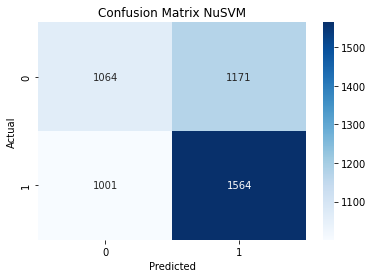

In [203]:
# Define the sliding window parameters
train_window = 1200
test_window = 30


prices_total = pd.DataFrame()
pred_total = pd.DataFrame()
y_train_total = pd.DataFrame()
y_test_total = pd.DataFrame()
ret_total = pd.DataFrame()
ret_test_total = pd.DataFrame()
pred_proba_total = pd.DataFrame()


input_cols = X_add_ff.columns
market_prices = data_download('^GSPC', startDate, endDate)['close']
# tickers =['NEE', 'ORCL', 'LIN', 'COST', 'PG', 'CVX', 'ADBE', 'LLY', 'NOW', 'ADP',
#        'AMAT', 'SPGI', 'ABBV', 'TMO', 'INTU', 'LOW', 'GOOGL', 'ACN', 'GOOG', 'HD'] #для сеточки


# tickers = ['KO', 'RTX', 'AVGO', 'AMGN', 'TMUS', 'BMY', 'HD', 'DE', 'TXN', 'AMT',
#        'INTC', 'MRK', 'COP', 'ABBV', 'WFC', 'C', 'CI', 'META', 'SBUX', 'INTU']



tickers =['SO', 'ABBV', 'CMCSA', 'DIS', 'ORCL', 'TGT', 'BMY', 'TXN', 'KO', 'NVDA',
           'ADP', 'NEE', 'ABT', 'V', 'ADBE', 'ACN', 'BABA', 'NOW', 'GOOGL','GOOG']

# tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'TSLA', 'JPM', 'JNJ', 'V',
#            'WMT', 'PG', 'BAC', 'UNH', 'NVDA', 'MA', 'HD', 'DIS', 'VZ', 'CRM', 'PYPL',
#            'KO', 'ADBE', 'INTC', 'NFLX', 'PFE', 'ABT', 'T', 'BMY', 'MRK', 'ACN', 'XOM',
#            'CSCO', 'CVX', 'BA', 'CMCSA', 'WFC', 'PEP', 'GOOG', 'ORCL', 'COST', 'MCD', 
#            'ABBV', 'MDT', 'NKE', 'AMGN', 'TXN', 'NEE', 'MMM', 'HON', 'SBUX', 'NVS',
#            'LMT', 'RTX', 'UNP', 'TMUS', 'DHR', 'UPS', 'IBM', 'BABA', 'QCOM', 'AMT', 
#            'TMO', 'AVGO', 'CVS', 'LIN', 'DE', 'AXP', 'CAT', 'LRCX', 'WBA', 
#            'GE', 'SO', 'LOW', 'D', 'MO', 'C', 'SPGI', 'COP', 'BLK', 'NOW', 
#            'CME', 'GS', 'INTU', 'FDX', 'VRTX','CI', 'ADP', 'TGT',
#            'AMAT', 'DUK', 'TJX', 'GM', 'MS', 'SCHW']


# Loop over the sliding windows

for i in tqdm(range(0, len(y) - train_window - test_window + 1, test_window)):
    
    pred_class_in_window = pd.DataFrame()    
    y_train_in_window = pd.DataFrame()
    y_test_in_window = pd.DataFrame()
    ret_in_window = pd.DataFrame()
    prices_in_window = pd.DataFrame()
    ret_test_in_window = pd.DataFrame()
    pred_proba = pd.DataFrame()

#     ret_for_mrtz_total = pd.DataFrame()
    
    for ticker in tickers:
        
        #data download and preprocessing
        current_dataset = data_download(ticker,startDate, endDate)
        y = current_dataset.iloc[:, -1:]
        X = z_normalize(current_dataset.iloc[:,0:-1])
        
#         kb = KBinsDiscretizer(n_bins=2, encode='ordinal', strategy= "quantile")
#         kb.fit(y.values.reshape(-1,1))
#         y_binned = kb.transform(y.values.reshape(-1,1))
#         y_binned = pd.DataFrame(y_binned)
        
        #разбиваю доходности на два класса
        y_binned = []
        #y = np.array(y).reshape(-1,1)

        for val in y.values:
            if val > 0:
                y_binned.append([1])
            elif val <= 0:
                y_binned.append([0])
        
        # Extract the training and testing samples
        y_train_sample = pd.DataFrame(y_binned[i:i+train_window])
        X_train_sample = X.iloc[i:i+train_window, :]

        y_test_sample = pd.DataFrame(y_binned[i+train_window:i+train_window+test_window])
        X_test_sample = X.iloc[i+train_window:i+train_window+test_window]

        # Perform feature selection
        k = 20  # Number of top features to select
        selector = SelectKBest(score_func=f_classif, k=k)  
        X_train_selected = selector.fit_transform(X_train_sample, y_train_sample)
        X_test_selected = selector.transform(X_test_sample)

        #Pooling
        train_dataset = catboost.Pool(X_train_selected, y_train_sample) 
        test_dataset = catboost.Pool(X_test_selected, y_test_sample)

        # Train the CatBoost classifier
        model = svm.NuSVC(kernel='rbf', probability=True)
        
        model.fit(X_train_sample,y_train_sample)

        # Evaluate the model
        pred_class = model.predict_proba(X_test_sample)
        
        pred_class = pd.DataFrame(pred_class).iloc[:,1]
        pred_class_in_window[ticker] = pd.DataFrame(model.predict(X_test_sample))
        y_train_in_window[ticker] = y.iloc[i:i+train_window]
        y_test_in_window[ticker] = y_test_sample
        ret_test_in_window[ticker] = y.iloc[i+train_window:i+train_window+test_window].reset_index(drop = True)
        
        #predictions to views
        y_0 = []
        y_1 = []
        yy = np.array(pd.concat([pd.DataFrame(y.iloc[i:i+train_window].values), y_train_sample], axis = 1))
        
        for k in range(len(y_train_sample)):
            if yy[k,1] == 1:
                y_1.append(yy[k,0])
            else:
                y_0.append(yy[k,0])
                
                
        pred_ret = []
        for j in range(len(pred_class)):
            if pred_class[j] > 0.5:
                pred_ret.append(np.mean(y_1[-40:]))
            else: 
                pred_ret.append(np.mean(y_0[-40:]))    
        ret_in_window[ticker]= pred_ret      
        pred_proba[ticker] = pred_class   
        
#     #aggregate inf from loop
    pred_total = pd.concat([pred_total,pred_class_in_window], axis = 0) 
    pred_ret = pd.DataFrame(pred_ret)
    ret_total = pd.concat([ret_total,ret_in_window], axis = 0)
    y_train_total = pd.concat([y_train_total,pd.DataFrame(y_train_in_window.mean()).T], axis = 0) 
    y_test_total = pd.concat([y_test_total,y_test_in_window.reset_index(drop = True)], axis = 0) 
    
    ret_test_total = pd.concat([ret_test_total, ret_test_in_window], axis = 0)


acc = []
for i in range(len(tickers)):
    
    acc.append(accuracy_score(y_test_total.iloc[:,i], pred_total.iloc[:,i]))

    
print("MIN Accuracy Score: ", round(np.min(acc),3))
print("**************************")
print("MEAN Accuracy Score: ", round(np.mean(acc),3))
print("**************************")
print("MAX Accuracy Score: ", round(np.max(acc),3))
# ret_test_total = ret_test_total.T
dataaa = {0:acc}
acc_df = pd.DataFrame.from_dict(dataaa, orient='index', columns = tickers)
# acc_df

# Create confusion matrix
y_true = np.array(y_test_total).flatten()
y_pred = np.array(pred_total).flatten()

cm = confusion_matrix(y_true, y_pred)

# Create a heatmap
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

# Add labels, title, and axis ticks
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix NuSVM')

# Show the plot
plt.savefig('confusion_matrix_NuSVM.jpeg', dpi=300)
plt.show()

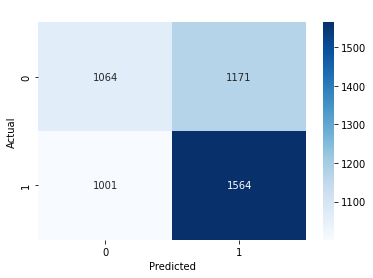

In [211]:
# Create confusion matrix
y_true = np.array(y_test_total).flatten()
y_pred = np.array(pred_total).flatten()

cm = confusion_matrix(y_true, y_pred)

# Create a heatmap
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

# Add labels, title, and axis ticks
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(' ')

# Show the plot
plt.savefig('confusion_matrix_NuSVM.jpeg', dpi=300)
plt.show()

In [213]:
acc_svm = pd.DataFrame(acc)
acc_svm.to_csv('acc_svm.csv', encoding='utf-8')

In [40]:
# ret_test_total.to_csv('test.csv', encoding='utf-8')
# ret_total.to_csv('NuSVM.csv', encoding='utf-8')

In [183]:
b =ret_test_total.values.flatten()
# b =y_test_total.values.flatten()
a = ret_total.values.flatten()

ab = pd.concat([pd.DataFrame(a),pd.DataFrame(b)], axis = 1)
ab.corr()

,0,0
0,1.000000,0.044051
0,0.044051,1.000000


In [182]:
corr_matrix = []
for t in tickers: 
    b =ret_test_total[t].values
    # b =y_test_total.values.flatten()
    a = pred_total[t].values
    ab = pd.concat([pd.DataFrame(a),pd.DataFrame(b)], axis = 1)
    c = ab.corr()
    corr_matrix.append(c.iloc[0,1])
# corr_matrix.columns = tickers  
print(corr_matrix)

[0.1297208423216567, 0.007936052115905121, 0.11617513064889351, 0.1197868685801168, 0.06719543189644986, -0.018179251658970046, 0.02117794163807098, 0.04359987467195289, 0.114079846674944, 0.017697384899418342, 0.03169539544916584, 0.10547399637893981, 0.03012581896668665, 0.1037994534553629, 0.008751375309811708, 0.12478060615986628, 0.09160987442394607, 0.06826311151933899, 0.08463386119797922, 0.06996667308180435]


In [19]:
# import seaborn as sns

# sns.set()
# sns.set_style("white")
# fig, ax = plt.subplots(figsize=(10,6))
# plt.plot(acc)
# plt.xlabel("Iteration")
# plt.ylabel("Accuracy")
# plt.title("Classifier Accuracy for Time Series Data")
# plt.show()

In [141]:
top_20 = acc_df.T.sort_values(by = 0).tail(20)
print(top_20.T.columns)

Index(['SO', 'ABBV', 'CMCSA', 'DIS', 'ORCL', 'TGT', 'BMY', 'TXN', 'KO', 'NVDA',
       'ADP', 'NEE', 'ABT', 'V', 'ADBE', 'ACN', 'BABA', 'NOW', 'GOOGL',
       'GOOG'],
      dtype='object')


In [42]:
top_20.T

,CVX,LOW,COST,PG,HD,AMAT,NEE,LLY,TMO,SPGI,LIN,ABBV,ADP,NOW,INTU,GOOG,ORCL,ADBE,GOOGL,ACN
0,0.420833,0.445833,0.454167,0.454167,0.4625,0.470833,0.475,0.483333,0.483333,0.491667,0.508333,0.508333,0.508333,0.5125,0.516667,0.520833,0.525,0.5375,0.545833,0.55


In [162]:
y_train_total

,SO,ABBV,CMCSA,DIS,ORCL,TGT,BMY,TXN,KO,NVDA,ADP,NEE,ABT,V,ADBE,ACN,BABA,NOW,GOOGL,GOOG
0,0.000161,0.000529,0.000456,0.000474,0.000413,0.000617,-0.000015,0.000893,0.000136,0.002341,0.000590,0.000795,0.000836,0.000898,0.001451,0.000754,0.001081,0.001830,0.000701,0.000730
0,0.000155,0.000444,0.000427,0.000433,0.000353,0.000668,-0.000091,0.000892,0.000076,0.002230,0.000521,0.000869,0.000841,0.000787,0.001353,0.000639,0.000989,0.001730,0.000815,0.000837
0,0.000147,0.000456,0.000502,0.000576,0.000440,0.000808,-0.000131,0.000883,0.000094,0.002018,0.000636,0.000713,0.000923,0.000841,0.001272,0.000662,0.000918,0.001549,0.000859,0.000879
0,0.000148,0.000461,0.000428,0.000533,0.000511,0.000848,-0.000154,0.000869,0.000141,0.002014,0.000567,0.000722,0.000859,0.000905,0.001384,0.000794,0.000850,0.001616,0.000957,0.000988
0,0.000174,0.000490,0.000452,0.000525,0.000582,0.000992,0.000148,0.000830,0.000210,0.002028,0.000660,0.000725,0.000800,0.000877,0.001378,0.000752,0.000631,0.001564,0.000929,0.000984
0,0.000191,0.000560,0.000492,0.000564,0.000692,0.001130,0.000264,0.000843,0.000263,0.002054,0.000717,0.000757,0.000900,0.000928,0.001461,0.000837,0.000519,0.001715,0.001001,0.001063
0,0.000262,0.000476,0.000452,0.000512,0.000652,0.000942,0.000121,0.000779,0.000252,0.001895,0.000612,0.000887,0.000999,0.000875,0.001534,0.000865,0.000510,0.001725,0.001080,0.001107
0,0.000209,0.000468,0.000348,0.000387,0.000756,0.001053,0.000015,0.000812,0.000233,0.001795,0.000603,0.000842,0.000896,0.000879,0.001473,0.000921,0.000511,0.001748,0.001033,0.001060


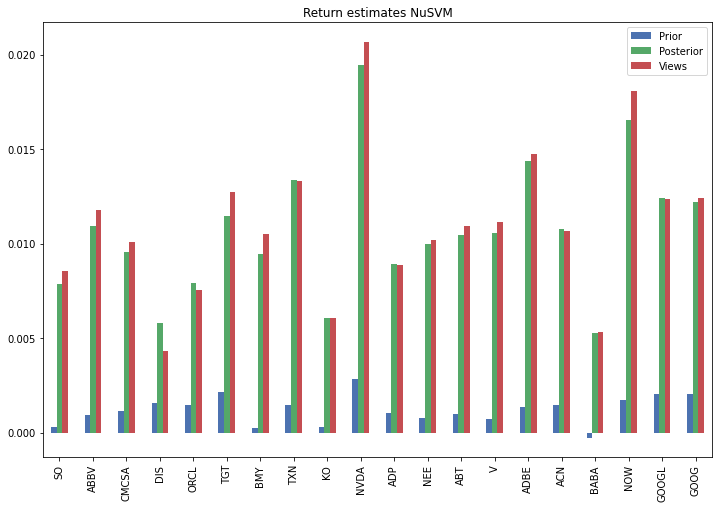

In [202]:
prices = pd.DataFrame() 
w_bl_total = pd.DataFrame()
w_m_total = pd.DataFrame()
market_prior_total = pd.DataFrame() 
y_train_total_all = pd.DataFrame()
ret_bl_total = pd.DataFrame()
view_total = pd.DataFrame()

confidences = []
for c in range(len(tickers)):
    confidences.append(0.8)


#prices for cov matrix
for ticker in tickers:
    current_dataset = data_download(ticker,startDate, endDate)
    prices[ticker] = current_dataset['close']
    
#creating market prior total list
for i in range(len(y_train_total)):
    for j in range(test_window):
        y_train_total_all = pd.concat([y_train_total_all,
                                       pd.DataFrame(y_train_total.iloc[i,-252:]).T], axis = 0)

        
cov_window = 252
# y_train_total_all = y_train_total_all    

#Black-Litterman part
ret_total=ret_total.reset_index(drop=True)    

delta_window = 756

for k in range(len(ret_total)):
    
    market_prior = y_train_total_all.iloc[k, :].values
    market_prior_total = pd.concat([market_prior_total,
                                    pd.DataFrame(market_prior, index = tickers).T], axis = 0)
    
    prices_in_window = prices.iloc[k + train_window - cov_window:k+train_window, :]
    
    
#     S = np.sqrt(prices_in_window.cov())
    S = risk_models.CovarianceShrinkage(prices_in_window,returns_data=False,
                                        frequency=1, log_returns=False).ledoit_wolf()
    
    delta = black_litterman.market_implied_risk_aversion(market_prices[k+train_window-delta_window:k+train_window])
#     delta = 100
    
    #creating views for BL model
    viewdict = {}
    for t in tickers:
        viewdict[t] = ret_total.loc[k,t] 
    view_df = pd.DataFrame(viewdict, index = [0])
    view_total = pd.concat([view_total,view_df], axis = 0)

    bl = BlackLittermanModel(cov_matrix = S,
                             pi = market_prior,
                             absolute_views=viewdict,
                             omega="idzorek",
#                              risk_aversion = delta,
                             view_confidences=confidences,
                             tau = 1)

    #Posterior estimate of returns
    ret_bl = bl.bl_returns()
    ret_bl_total = pd.concat([ret_bl_total, pd.DataFrame(ret_bl).T], axis = 0)
    

    S_bl = bl.bl_cov()                                 
    ef = EfficientFrontier(ret_bl, S_bl)
    ef.add_objective(objective_functions.L2_reg, gamma = 0.0001)
#     bl.optimize().add_constraint(lambda x : x >= -1)
#     ef.add_constraint(lambda x : x >= -1)
#     ef.add_constraint(lambda x : x <= 1)
    ef.efficient_risk(target_volatility = 0.02, market_neutral=False)
#     ef.min_volatility()
    
    weights = ef.clean_weights()
#     weights = bl.clean_weights()
#     weights = bl.bl_weights()
    w_bl = pd.DataFrame(weights, index = [0])
    w_bl_total = pd.concat([w_bl_total, w_bl], axis = 0)
    
    
    #Market
    ef_m = EfficientFrontier(market_prior, S)
#     ef_m.add_objective(objective_functions.L2_reg, gamma = 0.1)
#     ef_m.add_constraint(lambda x : x >= -1)
#     ef_m.add_constraint(lambda x : x <= 1)
    ef_m.efficient_risk(target_volatility = 0.02, market_neutral=False)
#     ef_m.min_volatility()
    
    weights_m = ef_m.clean_weights()
    w_m = pd.DataFrame(weights_m, index = [0])
    w_m_total = pd.concat([w_m_total, w_m], axis = 0)
    
    #table for compare estimaded returns 
#     rets_df = pd.DataFrame([market_prior, ret_bl, pd.Series(viewdict)],
#                                index=["Prior", "Posterior", "Views"]).T
    
rets_df_total = pd.DataFrame([market_prior_total.mean(), ret_bl_total.mean(), view_total.mean()],
                               index=["Prior", "Posterior", "Views"]).T
# print(rets_df_total)
rets_df_total.plot.bar(figsize=(12,8))
plt.title('Return estimates NuSVM')
# Show the plot
plt.savefig('Return estimates NuSVM.jpeg', dpi=300)

In [170]:
bl_portf_rets = []
mrkt_portf_rets = []
naive_portf_rets = []

#naive

w_naive = []
for t in tickers:
    w_naive.append(1/len(tickers))
w_naive = pd.DataFrame(w_naive).T

w_naive_total = pd.DataFrame()
for i in range(len(w_bl_total)):
    w_naive_total = pd.concat([w_naive_total,w_naive], axis = 0)
w_naive_total.columns = tickers

for i in range(len(ret_test_total.iloc[:,0])):
    
    bl_portf_rets.append(ret_test_total.iloc[i,:].T.dot(w_bl_total.iloc[i,:]))
    mrkt_portf_rets.append(ret_test_total.iloc[i,:].T.dot(w_m_total.iloc[i,:]))
    naive_portf_rets.append(ret_test_total.iloc[i,:].T.dot(w_naive_total.iloc[i,:]))
    
std_bl = np.std(bl_portf_rets)
std_m = np.std(mrkt_portf_rets)
std_n = np.std(naive_portf_rets)
    
itog = pd.DataFrame(
    {'BL': [round(sum(bl_portf_rets),4),round(std_bl,4), round(sum(bl_portf_rets)/std_bl,4)],
     'MRKT': [round(sum(mrkt_portf_rets),4), round(std_m, 4), round(sum(mrkt_portf_rets)/std_m,4)],
     'NAIVE': [round(sum(naive_portf_rets),4), round(std_n, 4), round(sum(naive_portf_rets)/std_n,4)]}, 
    index = ['C_ret: ','Std: ',  'SR: '])
print(itog)

              BL     MRKT    NAIVE
C_ret:    0.3840   0.2011   0.1366
Std:      0.0169   0.0152   0.0084
SR:      22.6627  13.2686  16.2973


In [212]:
df_rebalancing_bl = pd.DataFrame(np.nan, index=w_bl_total.index, columns=w_bl_total.columns)
for i in range(1, len(w_bl_total)):
    df_rebalancing_bl.iloc[i] = w_bl_total.iloc[i] - w_bl_total.iloc[i-1]

# print the result
rebalancing_bl = abs(df_rebalancing_bl).sum().sum()

df_rebalancing_m = pd.DataFrame(np.nan, index=w_m_total.index, columns=w_m_total.columns)
for i in range(1, len(w_bl_total)):
    df_rebalancing_m.iloc[i] = w_m_total.iloc[i] - w_m_total.iloc[i-1]

# print the result
rebalancing_m = abs(df_rebalancing_m).sum().sum()


rebalancing_bl, rebalancing_m

(67.55884999999999, 8.0593)

In [85]:
ind = y.index[train_window:train_window + test_window*((len(y) - train_window)//test_window)].values

In [171]:
bl_returns = pd.Series(bl_portf_rets, index = ind)
m_returns = pd.Series(mrkt_portf_rets, index = ind)
bl_returns.index = bl_returns.index.tz_localize('utc')
m_returns.index = m_returns.index.tz_localize('utc')

Start date,2020-12-17
End date,2021-11-30
Total months,11
,Backtest
Annual return,19.974%
Cumulative returns,18.938%
Annual volatility,24.107%
Sharpe ratio,0.88
Calmar ratio,1.11
Stability,0.59
Max drawdown,-18.018%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,18.02,2021-07-09,2021-09-29,NaT,NaN
1,11.82,2021-02-16,2021-03-03,2021-04-12,40
2,10.71,2021-04-14,2021-05-11,2021-05-21,28
3,5.45,2021-01-20,2021-01-26,2021-02-03,11
4,3.43,2020-12-17,2020-12-24,2021-01-07,16


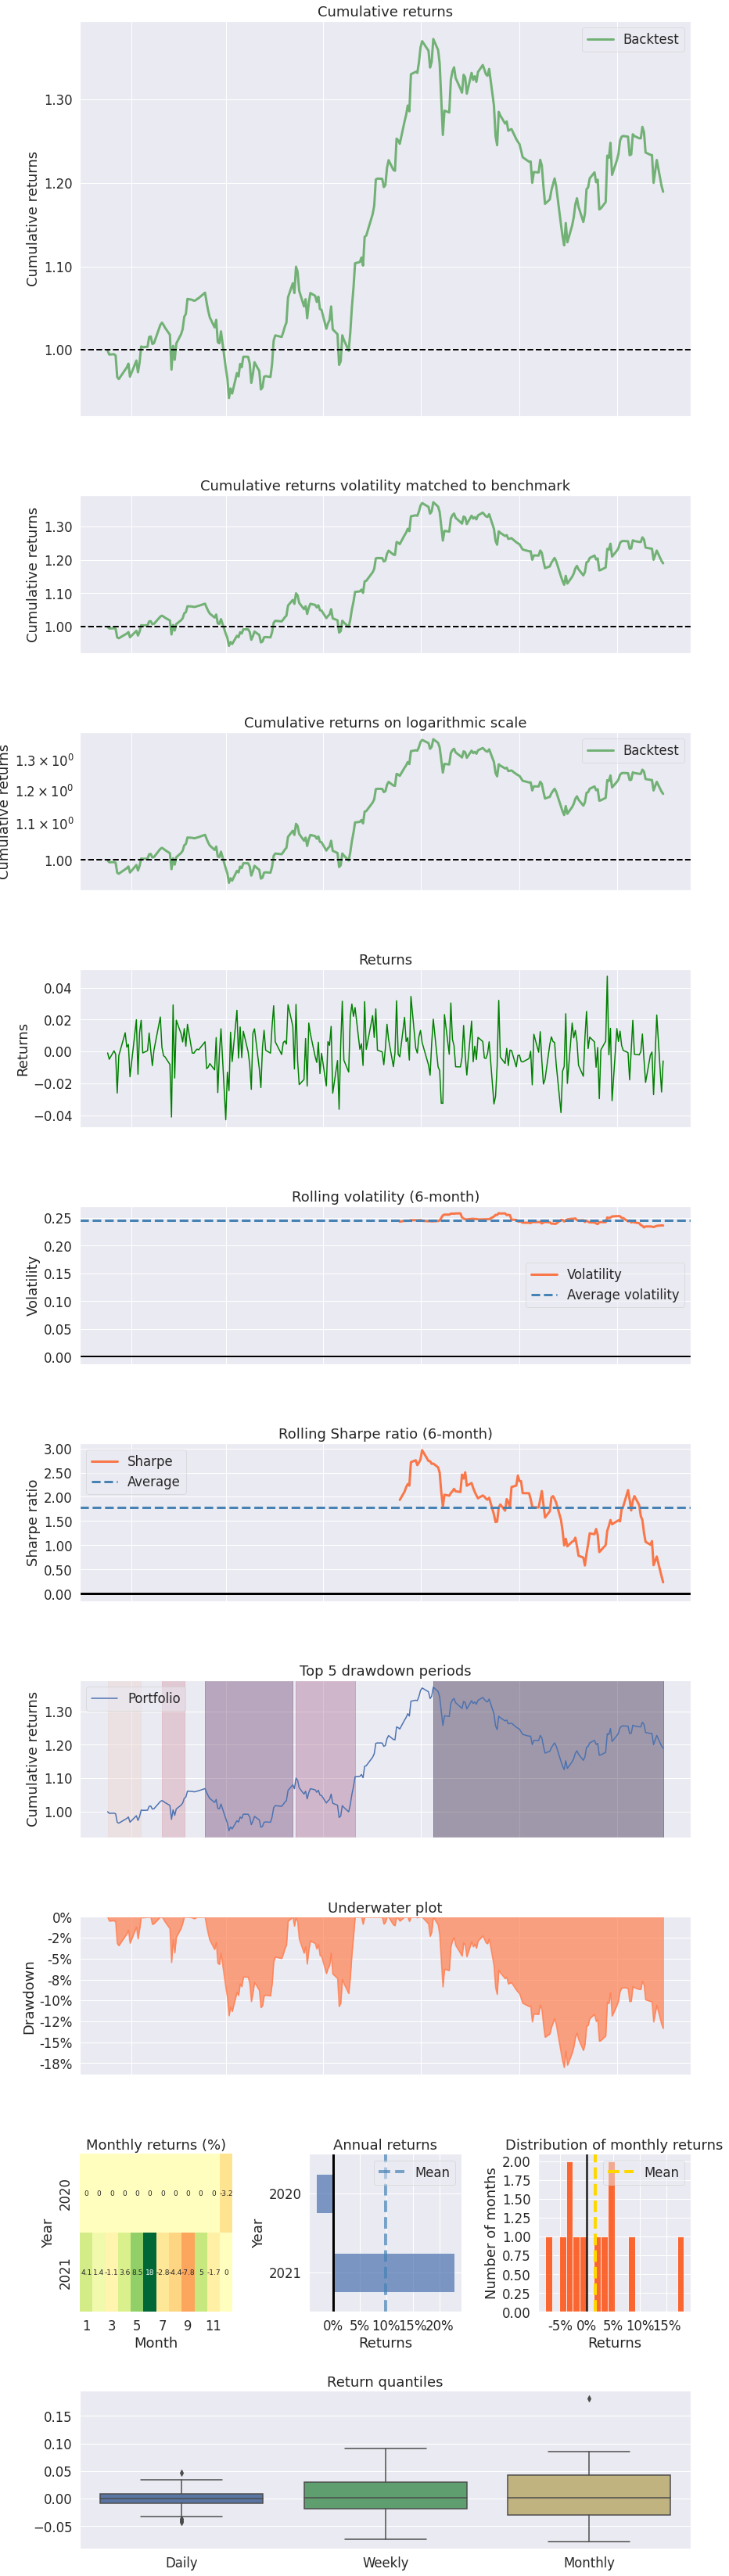

In [181]:
matplotlib.use('Agg')

f = pf.create_returns_tear_sheet(m_returns, return_fig=True)

# f.savefig('pyfolio_returns_catboost.jpeg', dpi=300)

Start date,2020-12-17
End date,2021-11-30
Total months,11
,Backtest
Annual return,44.33%
Cumulative returns,41.83%
Annual volatility,26.955%
Sharpe ratio,1.50
Calmar ratio,3.29
Stability,0.76
Max drawdown,-13.478%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,13.48,2021-02-04,2021-05-12,2021-06-03,86
1,12.64,2021-09-02,2021-10-01,2021-10-22,37
2,9.40,2021-11-18,2021-11-30,NaT,NaN
3,6.51,2021-07-02,2021-07-15,2021-08-03,23
4,5.96,2020-12-17,2020-12-23,2021-01-13,20


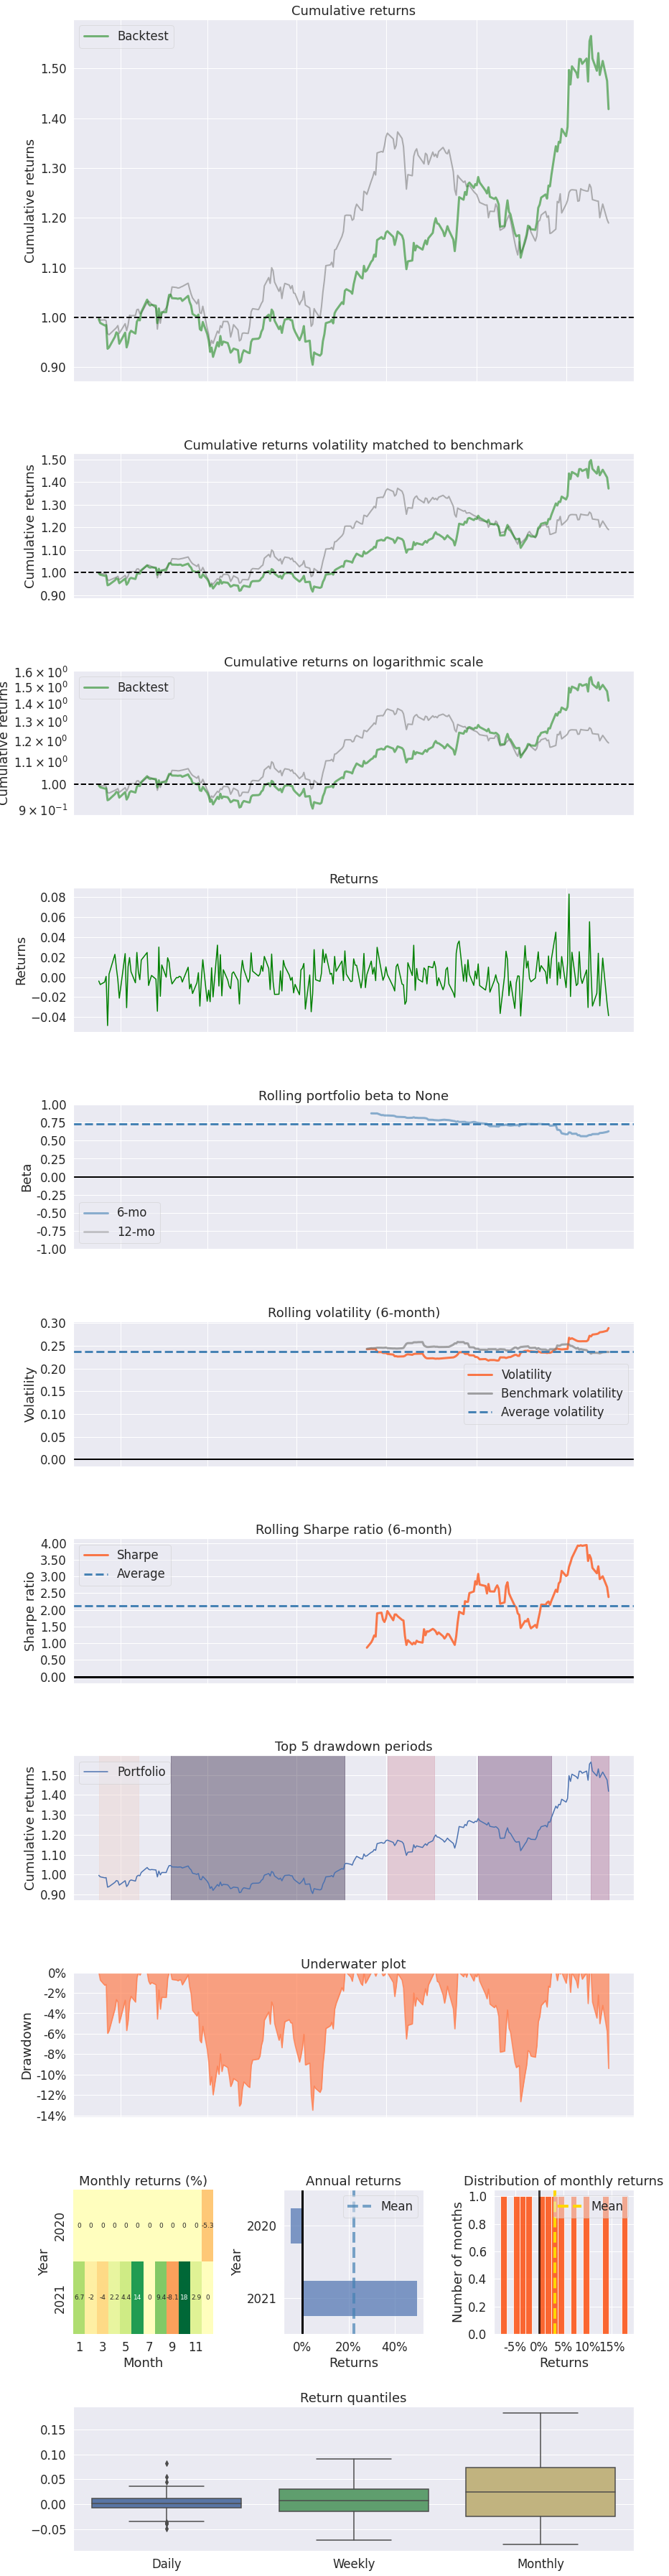

In [172]:
import matplotlib
matplotlib.use('Agg')

f = pf.create_returns_tear_sheet(bl_returns, benchmark_rets=m_returns, return_fig=True)

# f.savefig('pyfolio_returns_catboost.jpeg', dpi=300)

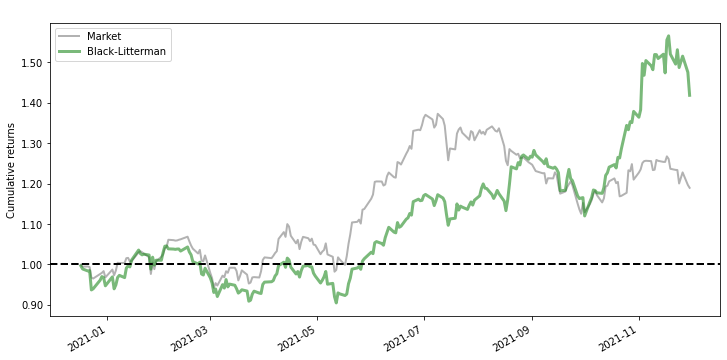

In [205]:
fig, ax = plt.subplots(figsize=(12,6))
pf.plotting.plot_rolling_returns(bl_returns,m_returns, ax=ax, legend_loc='best')
ax.legend(['Market', 'Black-Litterman'])
plt.title(' ')
plt.savefig('Cumulative_Returns_NuSVM.jpeg', dpi=300)

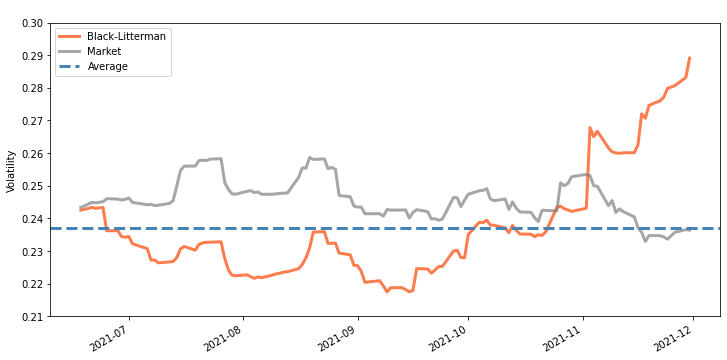

In [206]:
# pf.plotting.plot_rolling_returns(bl_returns, m_returns)
fig, ax = plt.subplots(figsize=(12,6))
pf.plotting.plot_rolling_volatility(bl_returns, m_returns, rolling_window=126)
ax.legend(['Black-Litterman', 'Market', 'Average'])
plt.title(' ')
ax.set_ylim([0.21, 0.3])
plt.savefig('rolling_volatility_NuSVM.jpeg', dpi=300)

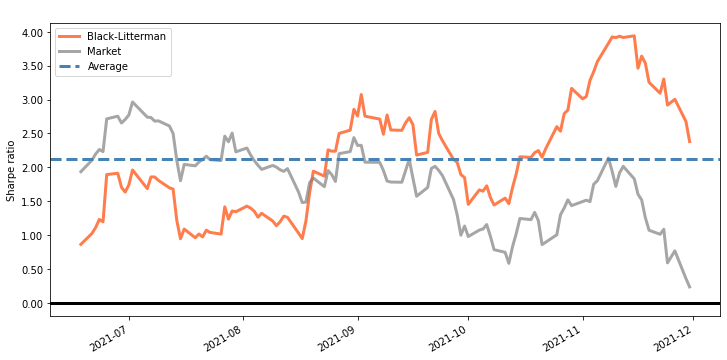

In [208]:
fig, ax = plt.subplots(figsize=(12,6))
pf.plotting.plot_rolling_sharpe(bl_returns,m_returns, figsize=(12,6))
ax.legend(['Black-Litterman', 'Market', 'Average'])
plt.title(' ')
plt.savefig('Rolling Sharpe ratio (6-month) NuSVM.jpeg', dpi=300)

Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,18.02,2021-07-09,2021-09-29,NaT,NaN
1,11.82,2021-02-16,2021-03-03,2021-04-12,40
2,10.71,2021-04-14,2021-05-11,2021-05-21,28
3,5.45,2021-01-20,2021-01-26,2021-02-03,11
4,3.43,2020-12-17,2020-12-24,2021-01-07,16


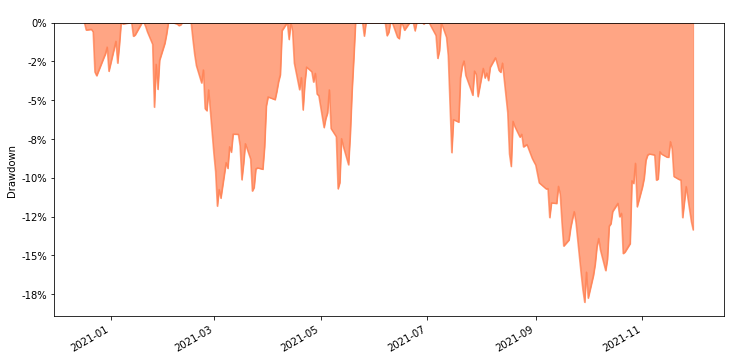

In [209]:
pf.plotting.show_worst_drawdown_periods(m_returns, top=5)
fig, ax = plt.subplots(figsize=(12,6))
pf.plotting.plot_drawdown_underwater(m_returns, figsize=(12,6))
plt.title(' ')
plt.savefig('Underwater Market portfolio NuSVM.jpeg', dpi=300)

Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,13.48,2021-02-04,2021-05-12,2021-06-03,86
1,12.64,2021-09-02,2021-10-01,2021-10-22,37
2,9.40,2021-11-18,2021-11-30,NaT,NaN
3,6.51,2021-07-02,2021-07-15,2021-08-03,23
4,5.96,2020-12-17,2020-12-23,2021-01-13,20


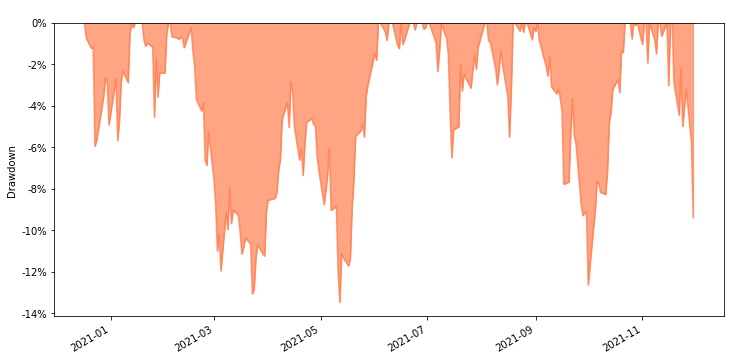

In [210]:
pf.plotting.show_worst_drawdown_periods(bl_returns, top=5)
fig, ax = plt.subplots(figsize=(12,6))
pf.plotting.plot_drawdown_underwater(bl_returns, figsize=(12,6))
plt.title(' ')
plt.savefig('Underwater Black-littarman portfolio NuSVM.jpeg', dpi=300)